In [11]:
import os
import sys
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2 as cv

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy
from keras.utils import img_to_array
from keras.utils.image_utils import smart_resize

import tensorflow as tf

print(f'Python: {sys.version}')

Python: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


In [2]:
RANDOM_STATE = 0

In [3]:
# Working with pre trained model 

#base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)
base_model = MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)


for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=52 , activation='softmax')(x)

# creating our model.
model = Model(base_model.input, x)

In [4]:
model.compile(optimizer='adam', loss=categorical_crossentropy , metrics=['accuracy'])

In [5]:
sessions = {}
directory_template = './data/mmi/Sessions/$session$/'
for session in os.listdir('./data/mmi/Sessions'):
    # Find XML filename
    directory = directory_template.replace('$session$', session)
    files = os.listdir(directory)
    xml_filename = directory + files[1]
    
    # Load AUs
    aus = []
    root = ET.parse(xml_filename).getroot()
    for au in root.iter('ActionUnit'):
        aus.append(au.attrib['Number'])
    
    # Load JPG filename
    jpg_filename = directory + files[0]
    
    sessions[session] = {
        'aus': aus,
        'img': jpg_filename
    }
    
assert len(sessions) == 493
print(f'{len(sessions)} sessions loaded')

493 sessions loaded


In [6]:
df_sessions = pd.DataFrame.from_dict(sessions, orient='index')
df_sessions.index.rename('session', inplace=True)

df_sessions_null = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) == 0]
df_sessions = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) != 0]
df_sessions = df_sessions.explode('aus')
df_sessions = df_sessions.sample(frac=1, random_state=RANDOM_STATE)

print(f'df_sessions_null: {df_sessions_null.shape}')
print(f'df_sessions: {df_sessions.shape}')
print()
df_sessions.info()
print()
df_sessions.head()

df_sessions_null: (265, 2)
df_sessions: (568, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 568 entries, 2594 to 2625
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   aus     568 non-null    object
 1   img     568 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB



,aus,img
session,,
2594,27,./data/mmi/Sessions/2594/S014-039.jpg
2565,12,./data/mmi/Sessions/2565/S014-010.jpg
2560,26,./data/mmi/Sessions/2560/S014-005.jpg
2503,36,./data/mmi/Sessions/2503/S004-064.jpg
2411,14,./data/mmi/Sessions/2411/S001-011.jpg


In [7]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2, 
    shear_range = 0.2, 
    horizontal_flip=True, 
    rescale = 1./255
)
train_data = train_datagen.flow_from_dataframe(
    dataframe = pd.concat([df_sessions] * 5).sample(frac=1),
    directory=".",
    x_col = "img",
    y_col = "aus",
    subset = "training",
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    target_size = (128,128)
)

Found 2840 validated image filenames belonging to 52 classes.


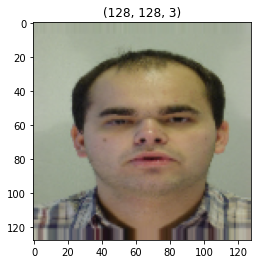

In [8]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

In [9]:
hist = model.fit(
    train_data,
    steps_per_epoch=10,
    epochs=100,
    #validation_data=test_data,
    validation_steps=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath='./results/model.h5',
            save_best_only=True,
            monitor="accuracy"
        )
    ]
)

print()
max_acc = max(hist.history['accuracy']) * 100
print(f'Accuracy: {max_acc = :.2f}%')

Epoch 1/100
10/10 [==============================] - 9s 771ms/step - loss: 3.9444 - accuracy: 0.0594
Epoch 2/100
10/10 [==============================] - 4s 409ms/step - loss: 3.9304 - accuracy: 0.0833
Epoch 3/100
10/10 [==============================] - 4s 362ms/step - loss: 3.9171 - accuracy: 0.1250
Epoch 4/100
10/10 [==============================] - 3s 339ms/step - loss: 3.9107 - accuracy: 0.0906
Epoch 5/100
10/10 [==============================] - 3s 333ms/step - loss: 3.8994 - accuracy: 0.1063
Epoch 6/100
10/10 [==============================] - 4s 349ms/step - loss: 3.8843 - accuracy: 0.1281
Epoch 7/100
10/10 [==============================] - 3s 328ms/step - loss: 3.8860 - accuracy: 0.0688
Epoch 8/100
10/10 [==============================] - 3s 345ms/step - loss: 3.8721 - accuracy: 0.1281
Epoch 9/100
10/10 [==============================] - 4s 349ms/step - loss: 3.8586 - accuracy: 0.1312
Epoch 10/100
10/10 [==============================] - 3s 328ms/step - loss: 3.8430 - accura

In [34]:
labels = np.sort(df_sessions['aus'].unique())
img_cv = cv.imread('./data/images/images/validation/angry/2770.jpg', cv.IMREAD_COLOR)
img_keras = img_to_array(img_cv)
img_keras = np.expand_dims(img_keras, axis=0)
img_keras = smart_resize(img_keras, (224, 224))
prediction = model.predict(img_keras)[0]
mean = prediction.mean()
std = prediction.std()
prediction_idx = np.argmax(prediction)
prediction_label = labels[prediction_idx]
prediction_prob = prediction[prediction_idx]

for i in range(len(prediction)):
    print(f'{labels[i]}: {prediction[i]}')


1/1 [==============================] - 0s 29ms/step
1: 0.026249542832374573
10: 0.02634640596807003
11: 0.016247812658548355
12: 0.022414900362491608
13: 0.016680698841810226
14: 0.016958117485046387
15: 0.025774354115128517
16: 0.02378445863723755
17: 0.04714788496494293
18: 0.025695722550153732
19: 0.014246951788663864
2: 0.0261630117893219
20: 0.019268730655312538
21: 0.025880666449666023
22: 0.024140123277902603
23: 0.017733033746480942
24: 0.027205223217606544
25: 0.07176654785871506
26: 0.05252532660961151
27: 0.015118769370019436
28: 0.010739400051534176
28B: 0.010540484450757504
28T: 0.011412600986659527
29: 0.009930472820997238
30: 0.011458547785878181
30L: 0.011347553692758083
30R: 0.01153117697685957
32B: 0.009605729021131992
32T: 0.009750320576131344
33: 0.009456702508032322
34: 0.009882193058729172
35: 0.009681460447609425
36: 0.014023948460817337
36B: 0.010198702104389668
36L: 0.008694030344486237
36R: 0.00951433926820755
36T: 0.009362319484353065
37: 0.009557005949318409